# 0. Import Libraries

In [1]:
import numpy as np
from scipy.stats import chi2
from scipy.optimize import minimize

import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import re
from functools import reduce

from factor_analyzer import FactorAnalyzer
import statsmodels.api as sm
from statsmodels.multivariate.factor import Factor
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.decomposition import FastICA
from sklearn.metrics import root_mean_squared_error

from scipy.stats import norm
from scipy.stats import norm, ks_2samp

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import gaussian_kde

/Users/eytanrozenblum/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1. Database construction

## 1.1. Web Scrapping for FOMC Meeting dates

In [2]:
# Function to extract and format the date
def extract_date(row):
    meeting = row['Meeting']
    year = row['Year']

    # Case 1: Match "YYYY, Month D (unscheduled) - YYYY" format
    match = re.search(r"(\d{4}),\s*(\w+)\s+(\d{1,2})", meeting)
    if match:
        _, month, day = match.groups()
        try:
            date_str = f"{day} {month} {year}"
            return datetime.strptime(date_str, "%d %B %Y").strftime("%d/%m/%Y")
        except ValueError:
            pass

    # Case 2: Match "Month D-D - YYYY" or "Month D - YYYY"
    match = re.search(r"(\w+)\s+(\d{1,2})(?:-(\d{1,2}))?", meeting)
    if match:
        month, day_start, _ = match.groups()
        try:
            date_str = f"{day_start} {month} {year}"
            return datetime.strptime(date_str, "%d %B %Y").strftime("%d/%m/%Y")
        except ValueError:
            pass

    # Case 3: Handle abbreviated months (e.g., "Apr/May 30-1 - YYYY")
    match = re.search(r"(\w+)(?:/(\w+))?\s+(\d{1,2})(?:-(\d{1,2}))?", meeting)
    if match:
        month1, month2, day_start, _ = match.groups()
        try:
            if month2:
                date_str = f"{day_start} {month1} {year}"
            else:
                date_str = f"{day_start} {month1} {year}"
            return datetime.strptime(date_str, "%d %b %Y").strftime("%d/%m/%Y")
        except ValueError:
            try:
                month1_full = datetime.strptime(month1, "%b").strftime("%B")
                if month2:
                    date_str = f"{day_start} {month1_full} {year}"
                else:
                    date_str = f"{day_start} {month1_full} {year}"
                return datetime.strptime(date_str, "%d %B %Y").strftime("%d/%m/%Y")
            except ValueError:
                pass

    # Default: Return None if no valid date is found
    return None

# Function to extract the nature of the meeting
def extract_nature(row):
    meeting = row['Meeting'].lower()
    if "conference call" in meeting:
        return "Conference Call"
    elif "meeting" in meeting:
        return "Meeting"
    elif "notation vote" in meeting:
        return "Notation Vote"
    elif "unscheduled" in meeting:
        return "Unscheduled"
    elif "cancelled" in meeting:
        return "Cancelled"
    else:
        return None  # Leave blank if no explicit nature is mentioned

# Initialize an empty list to store meeting dates
fomc_dates = []

# Scraping 2004–2018 from the historical materials page
for year in range(2004, 2019):
    url = f"https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        if year <= 2010:
            panel_headings = soup.find_all("div", class_="panel-heading")
            for panel in panel_headings:
                h5 = panel.find("h5")
                if h5:
                    meeting_text = h5.get_text(strip=True)
                    fomc_dates.append({"Year": year, "Meeting": meeting_text})
        else:
            panel_headings = soup.find_all("h5", class_="panel-heading panel-heading--shaded")
            for panel in panel_headings:
                meeting_text = panel.get_text(strip=True)
                fomc_dates.append({"Year": year, "Meeting": meeting_text})
    else:
        print(f"Failed to fetch data for year {year}")

# Scraping 2019–2024 from the new calendar page
url = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    panels = soup.find_all("div", class_="panel panel-default")
    for panel in panels:
        year_heading = panel.find("h4")
        if year_heading:
            year_text = year_heading.get_text(strip=True)
            year = int(year_text.split()[0])
            meeting_rows = panel.find_all("div", class_=["row fomc-meeting", "fomc-meeting--shaded row fomc-meeting"])
            for row in meeting_rows:
                month_div = row.find("div", class_="fomc-meeting__month")
                if month_div:
                    month = month_div.find("strong").get_text(strip=True)
                date_div = row.find("div", class_="fomc-meeting__date")
                if date_div:
                    day_range = date_div.get_text(strip=True)
                    fomc_dates.append({"Year": year, "Meeting": f"{month} {day_range}"})

# Convert the data into a DataFrame
fomc_data = pd.DataFrame(fomc_dates)

# Apply the functions to create new columns
fomc_data['Date'] = fomc_data.apply(extract_date, axis=1)
fomc_data['Nature'] = fomc_data.apply(extract_nature, axis=1)

# Keep only the last two columns (Date and Nature)
fomc_data = fomc_data[['Date', 'Nature']]

# Convert the Date column to a datetime format for sorting
fomc_data['Date'] = pd.to_datetime(fomc_data['Date'], format="%d/%m/%Y", errors='coerce')

# Sort the DataFrame by the Date column
fomc_data = fomc_data.sort_values(by='Date').reset_index(drop=True)

# Ensure the './data' directory exists
os.makedirs('./1. Database/Scrapping', exist_ok=True)

# Save the final DataFrame to the './data' directory
output_file_path = './1. Database/Scrapping/fomc_meeting_dates_2004_to_2024.csv'
fomc_data.to_csv(output_file_path, index=False)

# Display the processed and sorted DataFrame
print(fomc_data)

          Date   Nature
0   2004-01-27  Meeting
1   2004-03-16  Meeting
2   2004-05-04  Meeting
3   2004-06-29  Meeting
4   2004-08-10  Meeting
..         ...      ...
204 2026-06-16     None
205 2026-07-28     None
206 2026-09-15     None
207 2026-10-27     None
208 2026-12-08     None

[209 rows x 2 columns]


## 1.2. Database Construction With Bloomberg/ Refinitiv Data

### Bloomberg Data

In [3]:
# Paths to data
bloomberg_data_path = './1. Database/Financial Data/Bloomberg'
fomc_dates_path = './1. Database/Scrapping/fomc_meeting_dates_2004_to_2024.csv'
output_csv_path = './1. Database/Bloomberg_database.csv'  # Set your desired output path

# Load FOMC dates
fomc_dates = pd.read_csv(fomc_dates_path)

# Ensure the 'Date' column is in datetime format
fomc_dates['Date'] = pd.to_datetime(fomc_dates['Date'])
fomc_dates.sort_values('Date', inplace=True)

def detect_table_start(file_path, required_columns=['Date', 'PX_LAST']):
    """
    Detects the starting row of the data table in an Excel file by checking for required columns.
    """
    for i in range(0, 20):  # Assume headers are within the first 20 rows
        df = pd.read_excel(file_path, header=i)
        if all(col in df.columns for col in required_columns):
            return i
    raise ValueError(f"Required columns not found in {file_path}")

def find_price_column(df):
    """
    Finds the price column in the DataFrame.
    """
    possible_columns = ['PX_LAST', 'Dernier Prix', 'Clôture']
    for col in possible_columns:
        if col in df.columns:
            return col
    raise ValueError("Price column not found")

def process_special_file(file_path):
    """
    Processes special files with different column names.
    """
    asset_name = os.path.basename(file_path).split('.')[0]
    if asset_name == 'TOT_SPX':
        required_columns = ['Date', 'Dernier Prix']
    elif asset_name == 'IND_DJI':
        required_columns = ['Date', 'Clôture']
    else:
        raise ValueError(f"Special handling not defined for {asset_name}")

    header_row = detect_table_start(file_path, required_columns=required_columns)
    df = pd.read_excel(file_path, header=header_row)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    return df

def process_bloomberg_file(file_path, fomc_dates):
    """
    Processes a Bloomberg data file to extract prices around FOMC dates.
    """
    asset_name = os.path.basename(file_path).split('.')[0]

    # Handle special files
    if asset_name in ['TOT_SPX', 'IND_DJI']:
        df = process_special_file(file_path)
    else:
        header_row = detect_table_start(file_path)
        df = pd.read_excel(file_path, header=header_row)

    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

    price_col = find_price_column(df)
    df = df[['Date', price_col]].dropna()
    df.rename(columns={price_col: 'Price'}, inplace=True)

    prices_around_fomc = []

    for date in fomc_dates['Date']:
    # Define the window for day before (5 days before the meeting)
        start_date_before = date - pd.Timedelta(days=5)
        end_date_before = date - pd.Timedelta(days=1)
        df_before = df[(df['Date'] >= start_date_before) & (df['Date'] <= end_date_before)]
        if not df_before.empty:
            # Get the latest date in this range
            day_before = df_before['Date'].max()
            day_before_price = df_before.loc[df_before['Date'] == day_before, 'Price'].values[0]
        else:
            day_before_price = None

        # Define the window for day of (day of meeting to 5 days after)
        start_date_after = date
        end_date_after = date + pd.Timedelta(days=5)
        df_after = df[(df['Date'] >= start_date_after) & (df['Date'] <= end_date_after)]
        if not df_after.empty:
            # Get the earliest date in this range
            day_of = df_after['Date'].min()
            day_of_price = df_after.loc[df_after['Date'] == day_of, 'Price'].values[0]
        else:
            day_of_price = None

        prices_around_fomc.append({
            'Date': date,
            f'{asset_name.lower()}_before': day_before_price,
            f'{asset_name.lower()}_after': day_of_price
        })

    return pd.DataFrame(prices_around_fomc)

# Get list of Bloomberg files, excluding those ending with '_MID'
bloomberg_files = []
for f in os.listdir(bloomberg_data_path):
    name, ext = os.path.splitext(f)
    if ext == '.xlsx' and not name.endswith('_MID'):
        bloomberg_files.append(os.path.join(bloomberg_data_path, f))

# Process each file and collect the results
list_of_dfs = []
for file in bloomberg_files:
    try:
        df = process_bloomberg_file(file, fomc_dates)
        list_of_dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all dataframes into one
if list_of_dfs:
    combined_df = reduce(
        lambda left, right: pd.merge(left, right, on='Date', how='outer'),
        list_of_dfs
    )
else:
    combined_df = pd.DataFrame()

# Add the 'Nature' column from FOMC dates
combined_df = pd.merge(fomc_dates[['Date', 'Nature']], combined_df, on='Date', how='left')

# Reorder columns to have 'Date', 'Nature', and then the rest
cols = combined_df.columns.tolist()
cols.remove('Date')
cols.remove('Nature')
cols = ['Date', 'Nature'] + cols
combined_df = combined_df[cols]

# Sort the combined DataFrame by 'Date'
combined_df.sort_values('Date', inplace=True)

# Set max_date_in_bloomberg to the last day of available data (15th April 2024)
max_date_in_bloomberg = pd.Timestamp('2024-04-15')

# Filter out rows with a 'Date' greater than max_date_in_bloomberg
combined_df = combined_df[combined_df['Date'] <= max_date_in_bloomberg]

# Save the combined DataFrame to a CSV file
combined_df.to_csv(output_csv_path, index=False)

### Refinitiv Data

In [4]:
# Paths to data
refinitiv_data_path = './1. Database/Financial Data/Refinitiv'
fomc_dates_path = './1. Database/Scrapping/fomc_meeting_dates_2004_to_2024.csv'
output_csv_path = './1. Database/Refinitiv_database.csv'

# Load FOMC dates
fomc_dates = pd.read_csv(fomc_dates_path)

# Ensure the 'Date' column is in datetime format
fomc_dates['Date'] = pd.to_datetime(fomc_dates['Date'])
fomc_dates.sort_values('Date', inplace=True)

def detect_table_start(file_path, required_columns=['Exchange Date', 'Close']):
    """
    Detects the starting row of the data table in an Excel file by checking for required columns.
    """
    for i in range(0, 35):  # Assume headers are within the first 35 rows
        df = pd.read_excel(file_path, header=i)
        if all(col in df.columns for col in required_columns):
            return i
    raise ValueError(f"Required columns not found in {file_path}")

def find_price_column(df):
    """
    Finds the price column in the DataFrame.
    """
    possible_columns = ['Close']
    for col in possible_columns:
        if col in df.columns:
            return col
    raise ValueError("Price column not found")

def process_refinitiv_file(file_path, fomc_dates):
    """
    Processes a Refinitiv data file to extract prices around FOMC dates.
    """
    asset_name = os.path.basename(file_path).split('.')[0].lower()

    # Detect the starting row of the data table
    header_row = detect_table_start(file_path)
    df = pd.read_excel(file_path, header=header_row)

    # Ensure necessary columns are present
    required_columns = ['Exchange Date', 'Close']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Required columns not found in {file_path}")

    # Convert 'Exchange Date' to datetime and sort
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.sort_values('Exchange Date', inplace=True)

    # Find the price column
    price_col = find_price_column(df)
    df = df[['Exchange Date', price_col]].dropna()
    df.rename(columns={'Exchange Date': 'Date', price_col: 'Price'}, inplace=True)

    prices_around_fomc = []

    for date in fomc_dates['Date']:
        # Define the window for day before (5 days before the meeting)
        start_date_before = date - pd.Timedelta(days=5)
        end_date_before = date - pd.Timedelta(days=1)
        df_before = df[(df['Date'] >= start_date_before) & (df['Date'] <= end_date_before)]
        if not df_before.empty:
            # Get the latest date in this range
            day_before = df_before['Date'].max()
            day_before_price = df_before.loc[df_before['Date'] == day_before, 'Price'].values[0]
        else:
            day_before_price = None

        # Define the window for day of (day of meeting to 5 days after)
        start_date_after = date
        end_date_after = date + pd.Timedelta(days=5)
        df_after = df[(df['Date'] >= start_date_after) & (df['Date'] <= end_date_after)]
        if not df_after.empty:
            # Get the earliest date in this range
            day_of = df_after['Date'].min()
            day_of_price = df_after.loc[df_after['Date'] == day_of, 'Price'].values[0]
        else:
            day_of_price = None

        prices_around_fomc.append({
            'Date': date,
            f'{asset_name}_before': day_before_price,
            f'{asset_name}_after': day_of_price
        })

    return pd.DataFrame(prices_around_fomc)

# Get list of Refinitiv files
refinitiv_files = [
    os.path.join(refinitiv_data_path, f)
    for f in os.listdir(refinitiv_data_path)
    if f.endswith('.xlsx')
]

# Process each file and collect the results
list_of_dfs = []
for file in refinitiv_files:
    try:
        df = process_refinitiv_file(file, fomc_dates)
        list_of_dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all dataframes into one
if list_of_dfs:
    combined_df = reduce(
        lambda left, right: pd.merge(left, right, on='Date', how='outer'),
        list_of_dfs
    )
else:
    combined_df = pd.DataFrame()

# Add the 'Nature' column from FOMC dates
combined_df = pd.merge(fomc_dates[['Date', 'Nature']], combined_df, on='Date', how='left')

# Ensure 'Date' column is in datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Reorder columns to have 'Date', 'Nature', and then the rest
cols = combined_df.columns.tolist()
cols.remove('Date')
cols.remove('Nature')
cols = ['Date', 'Nature'] + cols
combined_df = combined_df[cols]

# Sort the combined DataFrame by 'Date'
combined_df.sort_values('Date', inplace=True)

max_date_in_refinitiv = pd.Timestamp('2024-04-15')

combined_df = combined_df[combined_df['Date'] <= max_date_in_refinitiv]

# Save the combined DataFrame to a CSV file
combined_df.to_csv(output_csv_path, index=False)

### Full Database

In [5]:
# File paths
bloomberg_file_path = './1. Database/bloomberg_database.csv'
refinitiv_file_path = './1. Database/refinitiv_database.csv'
output_file_path = './1. Database/merged_database.csv'

# Load datasets
try:
    bloomberg_data = pd.read_csv(bloomberg_file_path)
    refinitiv_data = pd.read_csv(refinitiv_file_path)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# Drop the 'Nature' column from the Refinitiv dataset as it is redundant
if 'Nature' in refinitiv_data.columns:
    refinitiv_data = refinitiv_data.drop(columns=['Nature'])

# Merge the two datasets on the "Date" column
merged_data = pd.merge(bloomberg_data, refinitiv_data, on='Date', how='outer')

# Drop rows with dates 2004-01-27 and 2004-03-16
dates_to_drop = ['2004-01-27', '2004-03-16']
merged_data = merged_data[~merged_data['Date'].isin(dates_to_drop)]

# Ensure "Nature" column from Bloomberg dataset remains second
columns_order = ['Date', 'Nature'] + [col for col in merged_data.columns if col not in ['Date', 'Nature']]
merged_data = merged_data[columns_order]

# Save the merged data
merged_data.to_csv(output_file_path, index=False)
print(f"Merged database saved to {output_file_path}")

Merged database saved to ./1. Database/merged_database.csv


In [6]:
# Create an empty DataFrame to store the differences
price_difference_data = pd.DataFrame()

# Add the 'Date' column to the new dataset
price_difference_data['Date'] = merged_data['Date']
price_difference_data['Nature'] = merged_data['Nature']

# Iterate over the columns to calculate differences
for column in merged_data.columns:
    if '_before' in column:
        asset_name = column.replace('_before', '')
        after_column = f"{asset_name}_after"
        if after_column in merged_data.columns:
            # Calculate the difference
            price_difference_data[asset_name] = (
                merged_data[after_column] - merged_data[column]
            )

# Save the new dataset
output_difference_file_path = './1. Database/price_difference_database.csv'
price_difference_data.to_csv(output_difference_file_path, index=False)

print(f"Price difference database saved to {output_difference_file_path}")

Price difference database saved to ./1. Database/price_difference_database.csv


In [7]:
price_difference_data.head()

,Date,Nature,eurusd,gb03_2_last,gb06_2_last,gt03_2_last,tot_spx,gt10_2_last,gt05_2_last,gb12_2_last,tech_ndx,gb30d_03m_fut,gt02_fut,gt05_fut,gb30d_09m_fut,gb30d_01m_fut,gt10_fut,bcom,gb30d_06m_fut
2,2004-05-04,Meeting,0.0154,0.031,0.031,0.042,2.06,0.066,0.057,NaN,6.82,0.010,0.031250,-0.078125,-0.005,0.005,-0.203125,1.510,-0.005
3,2004-06-29,Meeting,-0.0105,0.072,0.001,-0.046,2.85,-0.049,-0.055,NaN,12.58,-0.005,0.054688,0.218750,0.020,-0.005,0.343750,-0.961,0.010
4,2004-08-10,Meeting,-0.0036,0.011,0.073,0.173,13.82,0.033,0.072,NaN,27.88,-0.020,-0.203125,-0.343750,-0.100,-0.015,-0.359375,-0.290,-0.050
5,2004-09-21,Meeting,0.0160,0.021,0.032,0.028,7.10,-0.021,0.010,NaN,11.19,-0.005,-0.068750,-0.187500,-0.035,-0.005,-0.125000,2.588,-0.025
6,2004-11-10,Meeting,-0.0011,-0.020,-0.011,0.055,-1.17,0.013,0.031,NaN,-9.94,-0.005,-0.085938,-0.156250,-0.020,0.000,-0.265625,2.384,-0.010


In [8]:
price_difference_data.shape

(185, 19)

# 2. Analysis

## 2.1. Optimal Number of Factors

In [9]:
# Load the merged database
file_path = "./1. Database/price_difference_database.csv"
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])

In [10]:
print(data.columns)

Index(['Date', 'Nature', 'eurusd', 'gb03_2_last', 'gb06_2_last', 'gt03_2_last',
       'tot_spx', 'gt10_2_last', 'gt05_2_last', 'gb12_2_last', 'tech_ndx',
       'gb30d_03m_fut', 'gt02_fut', 'gt05_fut', 'gb30d_09m_fut',
       'gb30d_01m_fut', 'gt10_fut', 'bcom', 'gb30d_06m_fut'],
      dtype='object')


In [11]:
# Define asset groups
assets_treasury = [
    col for col in data.columns
    if any(term in col for term in ['gb03_2_last', 'gb06_2_last', 'gt03_2_last', 'gt10_2_last', 'gt05_2_last', 'gb12_2_last'])
]

assets_eurusd = [
    col for col in data.columns
    if any(term in col for term in ["eurusd"])
]

assets_equities_sp = [
    col for col in data.columns
    if any(term in col for term in ["tot_spx"])
]

assets_equities_nasdaq = [
    col for col in data.columns
    if any(term in col for term in ["tech_ndx"])
]

# Add 'Date' column explicitly to the selected columns
dataset_date = assets_treasury + ['Date']
dataset1_cols = assets_treasury + assets_eurusd
dataset2_cols = dataset1_cols + assets_equities_sp
dataset3_cols = dataset1_cols + assets_equities_nasdaq
dataset4_cols = dataset2_cols + assets_equities_nasdaq
dataset4_date_cols = dataset4_cols + ['Date']

# Create the datasets
dataset1 = data[dataset1_cols].dropna()
dataset2 = data[dataset2_cols].dropna()
dataset3 = data[dataset3_cols].dropna()
dataset4 = data[dataset4_cols].dropna()
dataset4_date = data[dataset4_date_cols].dropna()

# Extract Date after dropping NaN values
dataset_date = data[dataset_date].dropna()
cleaned_dates = dataset_date['Date']

# Create a dictionary of datasets
datasets = {
    'Dataset 1': dataset1,
    'Dataset 2': dataset2,
    'Dataset 3': dataset3,
    'Dataset 4': dataset4,
}

# Print a confirmation message
print("Datasets created successfully.")

Datasets created successfully.


In [12]:
dataset1.head()

,gb03_2_last,gb06_2_last,gt03_2_last,gt10_2_last,gt05_2_last,gb12_2_last,eurusd
46,-0.010,0.000,-0.016,-0.058,-0.022,0.010,0.0319
47,0.011,0.010,0.042,0.113,0.105,0.010,0.0152
48,0.034,0.018,-0.054,-0.114,-0.086,0.002,-0.0029
49,-0.003,0.027,0.028,-0.008,0.010,0.027,0.0063
50,0.003,0.028,0.043,0.053,0.056,0.021,0.0049


In [13]:
def ranktestfun(theta_flat, k, n, vecsigma, Vhat):
    # Reshape theta
    theta = theta_flat.reshape((k+1, n))
    sigma = theta[0, :]  # shape (n,)
    beta = theta[1:, :]  # shape (k, n)

    # Compute model-implied covariance matrix
    beta_T = beta.T  # shape (n, k)
    Sigma_model = beta_T @ beta_T.T + np.diag(sigma ** 2)  # shape (n, n)

    # Compute vecsigma_model
    index1, index2 = np.tril_indices(n)
    vecsigma_model = Sigma_model[index1, index2]

    # Compute residual
    diff = vecsigma - vecsigma_model

    # Compute distance
    try:
        Vhat_inv = np.linalg.inv(Vhat)
    except np.linalg.LinAlgError:
        Vhat_inv = np.linalg.pinv(Vhat)

    distance = diff.T @ Vhat_inv @ diff

    return distance

def ranktest(X, maxrank=3, minrank=0):
    X = np.asarray(X)
    T, n = X.shape

    # Normalize columns of X to unit variance
    meanX = np.mean(X, axis=0)
    covX = np.cov(X, rowvar=False)
    std_devs = np.sqrt(np.diag(covX))
    X = X / std_devs

    # Recompute mean and covariance
    meanX = np.mean(X, axis=0)
    covX = np.cov(X, rowvar=False)

    # Compute vech of covX (lower triangular elements including diagonal)
    index1, index2 = np.tril_indices(n)
    vecsigma = covX[index1, index2]
    bigN = len(vecsigma)

    # Compute varvecsig
    # Compute centered X
    X_centered = X - meanX

    # Compute S_tij = (X_centered)_ti * (X_centered)_tj
    # S is of shape (T, n, n)
    S = np.einsum('ti,tj->tij', X_centered, X_centered)

    # Compute numerator: numerator_ijkl = sum_t S_ti1i2 * S_ti3i4 / T^2
    numerator = np.einsum('tij, tkl -> ijkl', S, S) / T**2

    # Compute denominator: denominator_ijkl = covX_i1i2 * covX_i3i4 / T
    denominator = np.einsum('ij,kl->ijkl', covX, covX) / T

    varvecsig = numerator - denominator  # shape (n, n, n, n)

    # Build Vhat
    Vhat = varvecsig[index1[:, np.newaxis], index2[:, np.newaxis], index1[np.newaxis, :], index2[np.newaxis, :]]
    # Vhat is of shape (bigN, bigN)

    results = []

    # Loop over k
    for k in range(minrank, maxrank+1):
        print('\n\n-------------------------------------------------------------')
        print('\n\nTesting null of rank {}  (data has {} columns):\n\n'.format(k, n))
        df = (n - k)*(n - k + 1)//2 - n
        if df < 1:
            print('Rank test has no degrees of freedom for this test:')
            print('A factor model with {} factors can fit the data perfectly'.format(k))
        else:
            # Define initial guesses
            initial_guesses = []

            # Initial guess 1
            theta0 = np.vstack([np.ones(n) / 3, np.zeros((k, n))])
            theta0_flat = theta0.flatten()
            initial_guesses.append(theta0_flat)

            # Initial guess 2
            theta0 = np.vstack([np.ones(n) / 3, np.ones((k, n)) / (2 * k)])
            theta0_flat = theta0.flatten()
            initial_guesses.append(theta0_flat)

            # Initial guess 3
            temp = np.eye(k, n) / (2 * k)
            theta0 = np.vstack([np.ones(n) / 3, temp])
            theta0_flat = theta0.flatten()
            initial_guesses.append(theta0_flat)

            # Initial guess 4
            temp = np.fliplr(np.eye(k, n)) / (2 * k)
            theta0 = np.vstack([np.ones(n) / 3, temp])
            theta0_flat = theta0.flatten()
            initial_guesses.append(theta0_flat)

            minvals = []
            minthetas = []

            for theta0_flat in initial_guesses:
                res = minimize(ranktestfun, theta0_flat, args=(k, n, vecsigma, Vhat), method='BFGS', options={'maxiter':2000})
                minvals.append(res.fun)
                minthetas.append(res.x.reshape((k+1, n)))

            minval = min(minvals)
            idx = minvals.index(minval)
            mintheta = minthetas[idx]

            # Print out results
            print('white noise std devs:', ' '.join(['{:6.4f}'.format(abs(s)) for s in mintheta[0, :]]))
            for i in range(1, k+1):
                print('factor loadings     :', ' '.join(['{:6.4f}'.format(f) for f in mintheta[i, :]]))
            print('minimum distance    : {:6.4f}'.format(minval))
            print('degrees of freedom  :  {}'.format(df))
            critical_value = chi2.ppf(0.95, df)
            p_value = 1 - chi2.cdf(minval, df)
            print('chi^2 critical value: {:7.4f}'.format(critical_value))
            print('      p-value       : {:7.5f}'.format(p_value))

            result = {
                'k': k,
                'minval': minval,
                'mintheta': mintheta,
                'df': df,
                'critical_value': critical_value,
                'p_value': p_value,
            }
            results.append(result)
    print('\n')
    return results

In [14]:
# Call the ranktest function and store its output
results = {}
for dataset_name, dataset in datasets.items():
    print(f"Running rank test for {dataset_name}...\n")
    X = dataset.dropna().to_numpy()  # Ensure no missing values
    results[dataset_name] = ranktest(X)
    print("\n\n")

for dataset_name, result in results.items():
    print(f"Results for {dataset_name}:")
    for res in result:  # Each 'res' is a dictionary
        k = res["k"]
        minval = res["minval"]
        mintheta = res["mintheta"]
        df = res["df"]
        critical_value = res["critical_value"]
        p_value = res["p_value"]

        print(f"Rank {k}:")
        print(f"  Minimum distance: {minval:.4f}")
        print(f"  Degrees of freedom: {df}")
        print(f"  Critical value: {critical_value:.4f}")
        print(f"  p-value: {p_value:.5f}")
    print("\n")

Running rank test for Dataset 1...



-------------------------------------------------------------


Testing null of rank 0  (data has 7 columns):


white noise std devs: 0.2664 0.2769 0.1121 0.0995 0.0000 0.3067 0.6651
minimum distance    : 93.5970
degrees of freedom  :  21
chi^2 critical value: 32.6706
      p-value       : 0.00000


-------------------------------------------------------------


Testing null of rank 1  (data has 7 columns):


white noise std devs: 0.4088 0.3163 0.0000 0.1421 0.0000 0.3754 0.8311
factor loadings     : 0.1024 0.0407 0.3236 -0.0485 0.1166 0.1928 -0.2551
minimum distance    : 40.3932
degrees of freedom  :  14
chi^2 critical value: 23.6848
      p-value       : 0.00022


-------------------------------------------------------------


Testing null of rank 2  (data has 7 columns):


white noise std devs: 0.3354 0.3433 0.0861 0.1950 0.0000 0.3218 0.8494
factor loadings     : 0.0168 -0.0134 -0.3777 -0.7023 -0.6199 -0.0537 -0.1489
factor loadings     : 0.113

## 2.2. Interpretation of Factors

### 2.2.1. Independent Components Analysis

In [15]:
# To verify as ICA cannot handle missing values 
display(dataset4.isnull().sum())

gb03_2_last    0
gb06_2_last    0
gt03_2_last    0
gt10_2_last    0
gt05_2_last    0
gb12_2_last    0
eurusd         0
tot_spx        0
tech_ndx       0
dtype: int64

Mixing Matrix:
                  IC1       IC2
gb03_2_last  0.075806 -0.705327
gb06_2_last -0.114390 -0.873424
gt03_2_last -0.567079 -0.713769
gt10_2_last -0.702149 -0.476084
gt05_2_last -0.652727 -0.617206
gb12_2_last -0.265195 -0.837096
eurusd       0.151576  0.013975
tot_spx     -0.889911 -0.091408
tech_ndx    -0.847488 -0.028642


<Figure size 800x600 with 0 Axes>

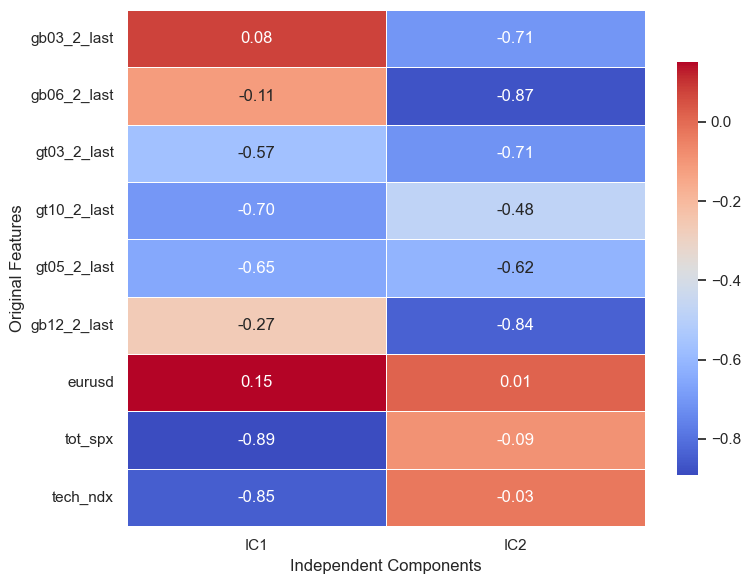

In [16]:
# Load and preprocess the data
data = dataset4.copy()
data = data.dropna()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Perform ICA
ica = FastICA(n_components=2, random_state=42)
S_ = ica.fit_transform(data_scaled)  # Independent components
A_ = ica.mixing_  # Mixing matrix

# Convert to DataFrame
components = pd.DataFrame(S_, columns=['IC1', 'IC2'])
mixing_matrix = pd.DataFrame(A_, columns=['IC1', 'IC2'], index=data.columns)

# Analyze the Mixing Matrix
print("Mixing Matrix:")
print(-mixing_matrix)

plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid")


# ============================================
# Heatmap of Mixing Matrix
# ============================================
plt.figure(figsize=(8,6))
sns.set_theme(style="white")

# Create a heatmap to visualize the mixing matrix
sns.heatmap(-mixing_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": 0.8})
plt.title('', fontsize=14, fontweight='bold', pad=12)
plt.xlabel('Independent Components', fontsize=12)
plt.ylabel('Original Features', fontsize=12)
plt.yticks(rotation=0)  # Keep feature names readable
plt.tight_layout()

heatmap_filename = 'mixing_matrix_heatmap.png'  # You can change the filename and format
plt.savefig(heatmap_filename, dpi=500, bbox_inches='tight')

plt.show()

### 2.2.2. Interpretation of the First Factor - Actions

In [17]:
dataset4_norm = dataset4.values
dataset4_norm = normalize(dataset4_norm, norm='l2')

pca = PCA(n_components=2)
dataset4_2d = pca.fit_transform(dataset4_norm)

explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()

# Print results
print(f"Explained Variance:\n{explained_variance}")
print(f"Total Explained Variance: {total_explained_variance:.4f}")

Explained Variance:
[0.81620315 0.15148278]
Total Explained Variance: 0.9677


In [18]:
dataset4_2d.shape

(139, 2)

In [19]:
# Load the dataset
data_refinitiv = pd.read_csv('./1. Database/refinitiv_database.csv')

# Ensure Date is in datetime format
data_refinitiv['Date'] = pd.to_datetime(data_refinitiv['Date'])

# Extract the day of the meeting (d) and the number of days in the month (D)
data_refinitiv['d'] = data_refinitiv['Date'].dt.day
data_refinitiv['D'] = data_refinitiv['Date'].dt.days_in_month

# Identify all columns with the word 'fut' in the name
fut_columns = [col for col in data_refinitiv.columns if 'fut' in col]

# Debug: Check identified columns
print("Futures Columns Identified:", fut_columns)

# Drop rows where all '_before' or '_after' columns are NaN
before_after_columns = [col for col in fut_columns if '_before' in col or '_after' in col]
data_refinitiv_cleaned = data_refinitiv.dropna(subset=before_after_columns, how='all').reset_index(drop=True)

# Iterate through each maturity and calculate the monetary policy surprise
mp_surprises = {}

for fut in fut_columns:
    if '_before' in fut:  # Ensure we are working with pairs
        base_name = fut.replace('_before', '')
        after_col = f"{base_name}_after"
        before_col = fut

        # Check if the 'after' column exists in the dataset
        if after_col in data_refinitiv_cleaned.columns:
            ff_t = data_refinitiv_cleaned[after_col]
            ff_t_minus_delta = data_refinitiv_cleaned[before_col]

            # For meetings in the last 7 days of the month, use unscaled change
            is_late_meeting = data_refinitiv_cleaned['D'] - data_refinitiv_cleaned['d'] < 7
            mp_surprise_scaled = (ff_t - ff_t_minus_delta) * (data_refinitiv_cleaned['D'] / (data_refinitiv_cleaned['D'] - data_refinitiv_cleaned['d']))
            mp_surprise_unscaled = data_refinitiv_cleaned[f'{base_name}_after'] - data_refinitiv_cleaned[f'{base_name}_before']
            
            # Use the appropriate calculation based on meeting timing
            data_refinitiv_cleaned[f'mp_surprise_{base_name}'] = mp_surprise_scaled
            data_refinitiv_cleaned.loc[is_late_meeting, f'mp_surprise_{base_name}'] = mp_surprise_unscaled

            # Store results if valid
            result = data_refinitiv_cleaned[['Date', f'mp_surprise_{base_name}']].dropna()
            if not result.empty:
                mp_surprises[base_name] = result

# Create a new DataFrame to store all monetary policy surprises
monetary_surprises = data_refinitiv_cleaned[['Date']].copy()

# Add all calculated surprises to the new DataFrame
for maturity, df in mp_surprises.items():
    # Merge each surprise column into the main DataFrame based on the Date
    monetary_surprises = monetary_surprises.merge(df, on='Date', how='left')

# Save the monetary surprises DataFrame to a CSV file
output_path = './1. Database/monetary_surprises.csv'
monetary_surprises.to_csv(output_path, index=False)

# Confirm the file was saved successfully
print(f"Monetary surprises saved to {output_path}")

Futures Columns Identified: ['gb30d_03m_fut_before', 'gb30d_03m_fut_after', 'gt02_fut_before', 'gt02_fut_after', 'gt05_fut_before', 'gt05_fut_after', 'gb30d_09m_fut_before', 'gb30d_09m_fut_after', 'gb30d_01m_fut_before', 'gb30d_01m_fut_after', 'gt10_fut_before', 'gt10_fut_after', 'gb30d_06m_fut_before', 'gb30d_06m_fut_after']
Monetary surprises saved to ./1. Database/monetary_surprises.csv


In [20]:
# Create 'dataset4_pc' DataFrame
dataset4_pc = pd.DataFrame({
    'Date': cleaned_dates,
    'Principal_Component_1': dataset4_2d[:, 0],
    'Principal_Component_2': dataset4_2d[:, 1]
})

# Step 2: Merge 'dataset4_pc' with 'mp_surprise_gb30d_01m_fut' on 'Date'
merged_data_monetary_surprise = pd.merge(dataset4_pc, monetary_surprises[['Date', 'mp_surprise_gb30d_01m_fut']], on='Date', how='inner')

# Step 3: Compute correlation for the specific monetary surprise
correlations = merged_data_monetary_surprise[['Principal_Component_1', 'Principal_Component_2', 'mp_surprise_gb30d_01m_fut']].corr()

# Extract correlations between PCs and 'mp_surprise_gb30d_01m_fut'
correlation_results = correlations.loc[
    ['Principal_Component_1', 'Principal_Component_2'], 'mp_surprise_gb30d_01m_fut'
]

# Display the correlation results
print("Correlations between Principal Components and 'mp_surprise_gb30d_01m_fut':")
print(correlation_results)

Correlations between Principal Components and 'mp_surprise_gb30d_01m_fut':
Principal_Component_1    0.041299
Principal_Component_2   -0.009793
Name: mp_surprise_gb30d_01m_fut, dtype: float64


In [21]:
merged_data_monetary_surprise.head()

,Date,Principal_Component_1,Principal_Component_2,mp_surprise_gb30d_01m_fut
0,2008-12-15,-1.188911,-0.086923,-0.038750
1,2009-01-16,0.798694,0.134734,-0.005167
2,2009-01-27,0.708195,0.457132,0.000000
3,2009-02-07,0.804186,0.024115,-0.006667
4,2009-03-17,0.789481,0.201004,-0.011071


In [22]:
# Extract F1 and F2 from your dataset
F1 = merged_data_monetary_surprise['Principal_Component_1'].values
F2 = merged_data_monetary_surprise['Principal_Component_2'].values

# Extract mp_surprise_gb30d_01m_fut as y
y = merged_data_monetary_surprise['mp_surprise_gb30d_01m_fut'].values

# Center the data
F = np.column_stack((F1, F2))
F_centered = F - np.mean(F, axis=0)
y_centered = y - np.mean(y)

# Compute the covariance vector b
b = F_centered.T @ y_centered  # Shape: (2,)

# Compute the optimal direction w
w = b / np.linalg.norm(b)

# Find an orthogonal vector u
u = np.array([-w[1], w[0]])  # Rotate w by 90 degrees
u = u / np.linalg.norm(u)

# Construct the rotation matrix R
R = np.column_stack((w, u))  # Shape: (2, 2)

# Verify that R is orthonormal
assert np.allclose(R.T @ R, np.identity(2)), "Rotation matrix R is not orthonormal."

# Rotate the centered data
Z = F_centered @ R

# Compute correlations with the target variable
correlation_Z1 = np.corrcoef(Z[:, 0], y_centered)[0, 1]
correlation_Z2 = np.corrcoef(Z[:, 1], y_centered)[0, 1]

# Print the correlations
print("Rotation matrix:")
print(R)
print("Correlation between Z1 and mp_surprise_gb30d_01m_fut:", correlation_Z1)
print("Correlation between Z2 and mp_surprise_gb30d_01m_fut:", correlation_Z2)

Rotation matrix:
[[ 0.9948225   0.10162768]
 [-0.10162768  0.9948225 ]]
Correlation between Z1 and mp_surprise_gb30d_01m_fut: 0.041689147194281476
Correlation between Z2 and mp_surprise_gb30d_01m_fut: -4.1835847459259e-18


### 2.2.3. Interpretation of the First Factor - Words

#### A/ Treat Hawkish-Dovish Index

In [23]:
# Step 2: Load the hawkish-dovish scale data
file_path = './1. Database/Scrapping/1805.11222v1.xlsx'
hawkish_dovish_data = pd.read_excel(file_path)

# Convert 'Date' columns in both datasets to datetime format
hawkish_dovish_data['Date'] = pd.to_datetime(hawkish_dovish_data['Full Date'])
dataset4_pc['Date'] = pd.to_datetime(dataset4_pc['Date'])

# Extract the relevant column ('our_measure') and the 'Date' column
hawkish_dovish_data = hawkish_dovish_data[['Date', 'our_measure']].dropna()

# Rename 'our_measure' to 'HD_index'
hawkish_dovish_data.rename(columns={'our_measure': 'HD_index'}, inplace=True)

hawkish_dovish_data.head()

,Date,HD_index
0,1996-01-30,-0.047170
1,1996-03-26,0.220779
2,1996-05-21,0.340909
3,1996-07-02,0.274194
4,1996-08-20,0.146667


In [24]:
# Create a column for the next ReleaseDate (to predict its sentiment)
hawkish_dovish_data['NextDate'] = hawkish_dovish_data['Date'].shift(-1)

# Drop the last row if NextReleaseDate is NaT (no next meeting)
hawkish_dovish_data = hawkish_dovish_data.dropna(subset=['NextDate'])

# Ensure dates are datetime
hawkish_dovish_data['Date'] = pd.to_datetime(hawkish_dovish_data['Date'])
hawkish_dovish_data['NextDate'] = pd.to_datetime(hawkish_dovish_data['NextDate'])

# Shift the target variable to the next FOMC meeting
hawkish_dovish_data['next_HD_index'] = hawkish_dovish_data['HD_index'].shift(-1)

# Drop the last row since it will have NaN in next_our_measure
hawkish_dovish_data = hawkish_dovish_data.dropna(subset=['next_HD_index'])

# Ensure 'Date' in hawkish_dovish_data is in datetime format
hawkish_dovish_data['Date'] = pd.to_datetime(hawkish_dovish_data['Date'])

# Rename 'Date' to 'DATE' in hawkish_dovish_data for merging
hawkish_dovish_data.rename(columns={'Date': 'DATE'}, inplace=True)

display(hawkish_dovish_data)

,DATE,HD_index,NextDate,next_HD_index
0,1996-01-30,-0.047170,1996-03-26,0.220779
1,1996-03-26,0.220779,1996-05-21,0.340909
2,1996-05-21,0.340909,1996-07-02,0.274194
3,1996-07-02,0.274194,1996-08-20,0.146667
4,1996-08-20,0.146667,1996-09-24,0.241758
...,...,...,...,...
207,2021-12-14,0.333333,2022-01-25,0.333333
208,2022-01-25,0.333333,2022-03-15,0.575000
209,2022-03-15,0.575000,2022-05-03,0.554545
210,2022-05-03,0.554545,2022-06-14,0.467153


#### B/ Get Macroeconomic Indicators

In [25]:
# Define the folder path where your CSV files are stored
folder_path = './1. Database/Financial Data/FRED_data'
output_path = './1. Database/macro_indicators.csv'

# Read each CSV file into a DataFrame using os.path.join
gdp_data = pd.read_csv(os.path.join(folder_path, 'GDP.csv'))
mortgage_data = pd.read_csv(os.path.join(folder_path, 'MORTGAGE30US.csv'))
pce_data = pd.read_csv(os.path.join(folder_path, 'PCEPI.csv'))
unrate_data = pd.read_csv(os.path.join(folder_path, 'UNRATE.csv'))

# Ensure the 'DATE' column is in datetime format for all DataFrames
for df in [gdp_data, mortgage_data, pce_data, unrate_data]:
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# Resample GDP data to monthly frequency using forward fill
gdp_data_clean = gdp_data
if gdp_data_clean['DATE'].isna().any():
    print("Invalid dates found in the dataset. Please clean the data.")
    raise ValueError("Invalid dates present in the dataset.")

gdp_data_clean.set_index('DATE', inplace=True)
gdp_data_monthly = gdp_data_clean.resample('MS').ffill()
gdp_data_monthly.reset_index(inplace=True)

In [26]:
# Merge the DataFrames on the 'date' column
merged_data = pd.merge(gdp_data_monthly, mortgage_data, on='DATE', how='outer')
merged_data = pd.merge(merged_data, pce_data, on='DATE', how='outer')
merged_data = pd.merge(merged_data, unrate_data, on='DATE', how='outer')

# Drop rows where 'DATE' is before 1995
merged_data = merged_data[merged_data['DATE'] >= '1995-01-01']

# Save the merged DataFrame to a CSV file
merged_data.to_csv(output_path, index=False)

print(f"Data merged successfully and saved to {output_path}")

merged_data.head()

Data merged successfully and saved to ./1. Database/macro_indicators.csv


,DATE,GDP,MORTGAGE30US,PCEPI,UNRATE
432,1995-01-01,7522.289,9.1475,67.127,5.6
433,1995-02-01,7522.289,8.8275,67.246,5.4
434,1995-03-01,7522.289,8.4620,67.370,5.4
435,1995-04-01,7580.997,8.3200,67.547,5.8
436,1995-05-01,7580.997,7.9550,67.651,5.6


In [27]:
macro_data = merged_data

# Define a function to calculate growth while leaving blank cells for NaN values
def calculate_growth_with_blank(column):
    # Forward fill missing values and calculate percentage change
    growth = column.ffill().pct_change() * 100
    return growth

# Loop through each numeric column (exclude 'DATE') to calculate growth
for col in macro_data.columns:
    if col != 'DATE':  # Skip 'DATE' column
        macro_data[f'{col}_GROWTH'] = calculate_growth_with_blank(macro_data[col])

# Display the resulting DataFrame with the appended growth columns
macro_data.head()

,DATE,GDP,MORTGAGE30US,PCEPI,UNRATE,GDP_GROWTH,MORTGAGE30US_GROWTH,PCEPI_GROWTH,UNRATE_GROWTH
432,1995-01-01,7522.289,9.1475,67.127,5.6,NaN,NaN,NaN,NaN
433,1995-02-01,7522.289,8.8275,67.246,5.4,0.000000,-3.498224,0.177276,-3.571429
434,1995-03-01,7522.289,8.4620,67.370,5.4,0.000000,-4.140470,0.184398,0.000000
435,1995-04-01,7580.997,8.3200,67.547,5.8,0.780454,-1.678090,0.262728,7.407407
436,1995-05-01,7580.997,7.9550,67.651,5.6,0.000000,-4.387019,0.153967,-3.448276


In [28]:
# Define thresholds for each growth column
thresholds = {
    'GDP_GROWTH': 5,
    'MORTGAGE30US_GROWTH': 5,
    'PCEPI_GROWTH': 2,
    'UNRATE_GROWTH': 5
}

# Create a copy of macro_data
macro_data_clean = macro_data.copy()

# Loop through the thresholds and filter rows for each condition
for col, threshold in thresholds.items():
    if col in macro_data_clean.columns:  # Check if the column exists
        macro_data_clean = macro_data_clean[macro_data_clean[col].abs() <= threshold]

# Print the shape of the cleaned DataFrame
print(f"macro_data shape is {macro_data.shape}. macro_data_clean shape is {macro_data_clean.shape}.")

macro_data shape is (359, 9). macro_data_clean shape is (280, 9).


#### C/ Regression

##### i. Pre-processing and EDA

In [29]:
# Perform an asof merge
# This ensures the closest date in macro_data (before or equal to the given date in hawkish_dovish_data) is matched
regression_df = pd.merge_asof(
    hawkish_dovish_data.sort_values(by='DATE'),  # Sort by DATE for merge_asof
    macro_data_clean.sort_values(by='DATE'),          # Sort by DATE for merge_asof
    on='DATE',                                  # Merge key
    direction='backward'                        # Match the most recent prior date
)

regression_df = regression_df.drop(columns=['NextDate', 'next_HD_index'])

# Add a column HD_index_t-1 by shifting HD_index down by one
regression_df['HD_index_t-1'] = regression_df['HD_index'].shift(1)
regression_df = regression_df.dropna(subset=['HD_index_t-1']).reset_index(drop=True)

# Display the resulting regression DataFrame
regression_df.head()

,DATE,HD_index,GDP,MORTGAGE30US,PCEPI,UNRATE,GDP_GROWTH,MORTGAGE30US_GROWTH,PCEPI_GROWTH,UNRATE_GROWTH,HD_index_t-1
0,1996-03-26,0.220779,7868.468,7.075,68.560,5.5,0.000000,0.640114,0.157775,-1.785714,-0.047170
1,1996-05-21,0.340909,8032.840,8.070,69.092,5.6,0.000000,1.829653,0.172531,0.000000,0.220779
2,1996-07-02,0.274194,8131.408,8.245,69.237,5.5,1.227063,-0.901442,0.211316,3.773585,0.340909
3,1996-08-20,0.146667,8131.408,8.245,69.237,5.5,1.227063,-0.901442,0.211316,3.773585,0.274194
4,1996-09-24,0.241758,8131.408,8.230,69.499,5.2,0.000000,2.849288,0.282816,1.960784,0.146667


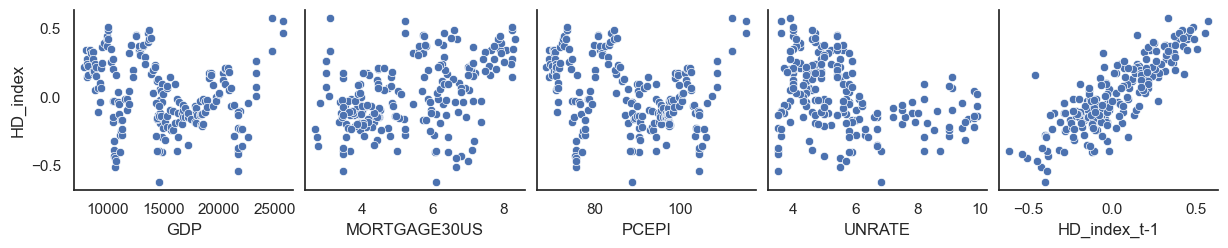

In [30]:
# Pairplot to visualize relationships
sns.pairplot(regression_df, x_vars=['GDP', 'MORTGAGE30US', 'PCEPI', 'UNRATE', 'HD_index_t-1'], y_vars='HD_index', kind='scatter')
plt.show()

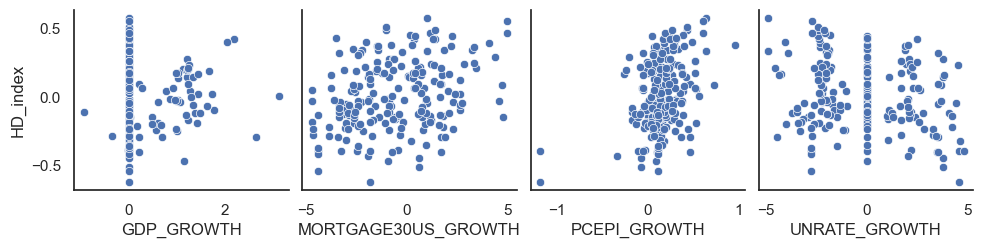

In [31]:
# Pairplot to visualize relationships
sns.pairplot(regression_df, x_vars=['GDP_GROWTH', 'MORTGAGE30US_GROWTH', 'PCEPI_GROWTH', 'UNRATE_GROWTH'], y_vars='HD_index', kind='scatter')
plt.show()

                   GDP  MORTGAGE30US     PCEPI    UNRATE  HD_index_t-1  \
GDP           1.000000     -0.872977  0.990786 -0.043749     -0.214696   
MORTGAGE30US -0.872977      1.000000 -0.899859 -0.272010      0.437533   
PCEPI         0.990786     -0.899859  1.000000  0.066216     -0.257563   
UNRATE       -0.043749     -0.272010  0.066216  1.000000     -0.392413   
HD_index_t-1 -0.214696      0.437533 -0.257563 -0.392413      1.000000   
HD_index     -0.199903      0.396884 -0.245261 -0.362452      0.843221   

              HD_index  
GDP          -0.199903  
MORTGAGE30US  0.396884  
PCEPI        -0.245261  
UNRATE       -0.362452  
HD_index_t-1  0.843221  
HD_index      1.000000  


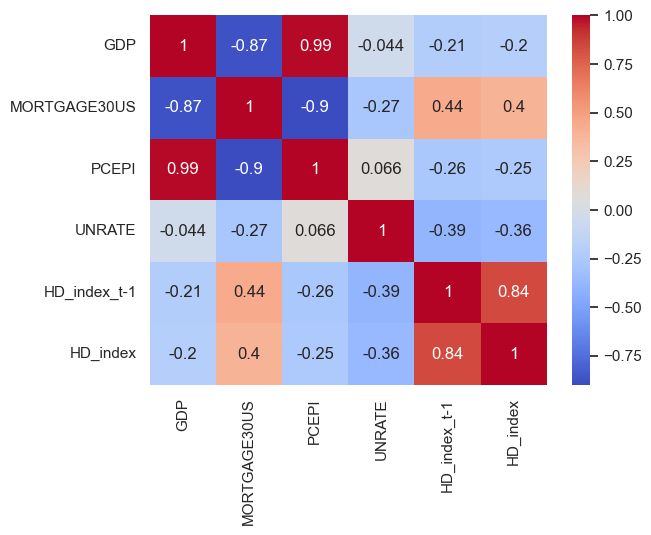

In [32]:
# Calculate correlation matrix
correlation_matrix = regression_df[['GDP', 'MORTGAGE30US', 'PCEPI', 'UNRATE', 'HD_index_t-1', 'HD_index']].corr()
print(correlation_matrix)

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

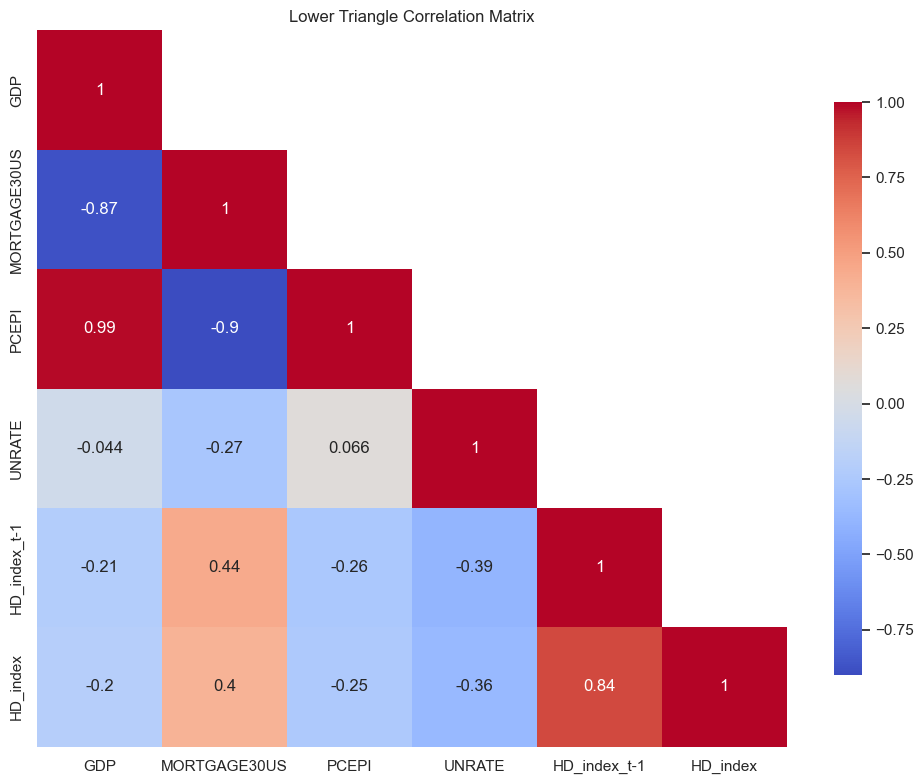

In [33]:
# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Create a heatmap with the mask
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', cbar_kws={'shrink': 0.8})
plt.title("Lower Triangle Correlation Matrix")
plt.tight_layout()

# Save the plot
plt.savefig("./lower_triangle_correlation_matrix.png")
plt.show()

In [34]:
# VIF Analysis
variables = regression_df[['UNRATE', 'GDP_GROWTH', 'HD_index_t-1']]
variables_with_constant = variables  # Add a constant column for intercept in the VIF calculation
vif_data = pd.DataFrame()
vif_data['Variable'] = variables_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(variables_with_constant.values, i) for i in range(variables_with_constant.shape[1])]

print(vif_data)

       Variable       VIF
0        UNRATE  1.209244
1    GDP_GROWTH  1.205513
2  HD_index_t-1  1.003398


                     GDP_GROWTH  MORTGAGE30US_GROWTH  PCEPI_GROWTH  \
GDP_GROWTH             1.000000             0.036620      0.102772   
MORTGAGE30US_GROWTH    0.036620             1.000000      0.197745   
PCEPI_GROWTH           0.102772             0.197745      1.000000   
UNRATE_GROWTH         -0.068242            -0.046267     -0.113817   
HD_index               0.005143             0.298526      0.382008   

                     UNRATE_GROWTH  HD_index  
GDP_GROWTH               -0.068242  0.005143  
MORTGAGE30US_GROWTH      -0.046267  0.298526  
PCEPI_GROWTH             -0.113817  0.382008  
UNRATE_GROWTH             1.000000 -0.230241  
HD_index                 -0.230241  1.000000  


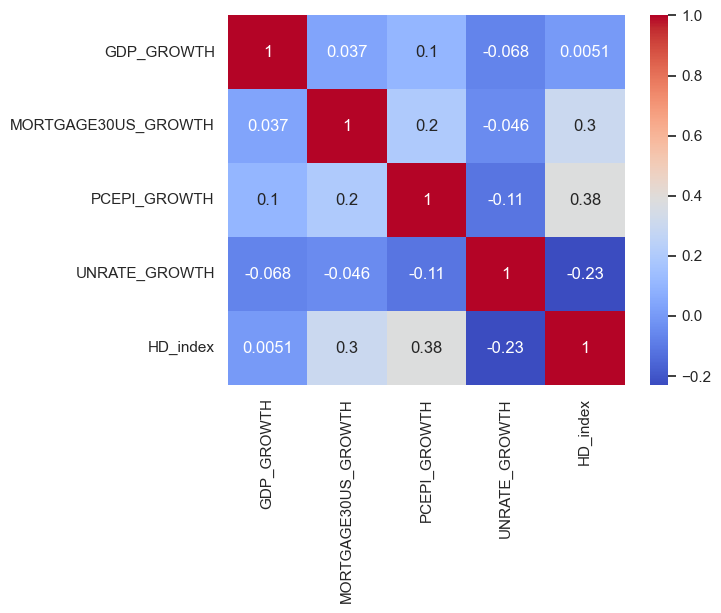

In [35]:
# Calculate correlation matrix
correlation_matrix = regression_df[['GDP_GROWTH', 'MORTGAGE30US_GROWTH', 'PCEPI_GROWTH', 'UNRATE_GROWTH', 'HD_index']].corr()
print(correlation_matrix)

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

##### ii. Regression - Different Splits

In [36]:
################
# Random Split #
################

# Drop unnecessary columns and prepare data
feature_columns = [col for col in regression_df.columns if col not in ['DATE', 'HD_index']]
X = regression_df[feature_columns]
y = regression_df['HD_index']

# Split the data randomly into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = []

# Iterate over combinations of features for k = 1 to 9
for k in range(1, len(feature_columns) + 1):
    for combination in combinations(feature_columns, k):
        # Select subset of features
        X_train_subset = X_train[list(combination)]
        X_test_subset = X_test[list(combination)]

        # Scale the subset
        X_train_scaled_subset = scaler.fit_transform(X_train_subset)
        X_test_scaled_subset = scaler.transform(X_test_subset)

        # Initialize models
        models = {
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'RandomForest': RandomForestRegressor(random_state=31415)
        }

        for model_name, model in models.items():
            # Train the model
            model.fit(X_train_scaled_subset, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test_scaled_subset)

            # Evaluate the model
            rmse = root_mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store the results
            results.append({
                'Model': model_name,
                'Features': combination,
                'k': k,
                'RMSE': rmse,
                'R2': r2
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by R2 score and display the best models
results_df = results_df.sort_values(by='R2', ascending=False)
results_df.head(10)

,Model,Features,k,RMSE,R2
43,RandomForest,"(GDP, PCEPI)",2,0.101725,0.854160
99,RandomForest,"(PCEPI, UNRATE)",2,0.106607,0.839827
211,RandomForest,"(GDP, PCEPI, UNRATE)",3,0.107093,0.838361
215,RandomForest,"(GDP, PCEPI, GDP_GROWTH)",3,0.108087,0.835349
379,RandomForest,"(PCEPI, UNRATE, GDP_GROWTH)",3,0.109967,0.829569
51,RandomForest,"(GDP, GDP_GROWTH)",2,0.110706,0.827273
603,RandomForest,"(GDP, PCEPI, UNRATE, GDP_GROWTH)",4,0.110814,0.826936
183,RandomForest,"(GDP, MORTGAGE30US, PCEPI)",3,0.111245,0.825586
47,RandomForest,"(GDP, UNRATE)",2,0.111973,0.823295
3,RandomForest,"(GDP,)",1,0.112328,0.822175


In [37]:
################################################
# Split Before/ After Access to Bloomberg Data #
################################################

# Drop unnecessary columns and prepare data
feature_columns = [col for col in regression_df.columns if col not in ['DATE', 'HD_index']]
X = regression_df[feature_columns]
y = regression_df['HD_index']

# Ensure 'DATE' is in datetime format
regression_df['DATE'] = pd.to_datetime(regression_df['DATE'])

# Split the data by date
train_data = regression_df[regression_df['DATE'] < '2004-01-27']
test_data = regression_df[regression_df['DATE'] >= '2004-01-27']

# Prepare train and test datasets
X_train = train_data[feature_columns]
y_train = train_data['HD_index']
X_test = test_data[feature_columns]
y_test = test_data['HD_index']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = []

# Iterate over combinations of features for k = 1 to 9
for k in range(1, len(feature_columns) + 1):
    for combination in combinations(feature_columns, k):
        # Select subset of features
        X_train_subset = X_train[list(combination)]
        X_test_subset = X_test[list(combination)]

        # Scale the subset
        X_train_scaled_subset = scaler.fit_transform(X_train_subset)
        X_test_scaled_subset = scaler.transform(X_test_subset)

        # Initialize models
        models = {
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'RandomForest': RandomForestRegressor(random_state=31415)
        }

        for model_name, model in models.items():
            # Train the model
            model.fit(X_train_scaled_subset, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test_scaled_subset)

            # Evaluate the model
            rmse = root_mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store the results
            results.append({
                'Model': model_name,
                'Features': combination,
                'k': k,
                'RMSE': rmse,
                'R2': r2
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by R2 score and display the best models
results_df = results_df.sort_values(by='R2', ascending=False)
results_df.head(10)

,Model,Features,k,RMSE,R2
137,Ridge,"(UNRATE, HD_index_t-1)",2,0.131067,0.692811
136,LinearRegression,"(UNRATE, HD_index_t-1)",2,0.131091,0.692702
32,LinearRegression,"(HD_index_t-1,)",1,0.131573,0.690433
33,Ridge,"(HD_index_t-1,)",1,0.131634,0.690151
165,Ridge,"(MORTGAGE30US_GROWTH, HD_index_t-1)",2,0.134656,0.675759
449,Ridge,"(UNRATE, GDP_GROWTH, HD_index_t-1)",3,0.134816,0.674988
164,LinearRegression,"(MORTGAGE30US_GROWTH, HD_index_t-1)",2,0.134995,0.674124
153,Ridge,"(GDP_GROWTH, HD_index_t-1)",2,0.135347,0.672422
152,LinearRegression,"(GDP_GROWTH, HD_index_t-1)",2,0.135510,0.671631
448,LinearRegression,"(UNRATE, GDP_GROWTH, HD_index_t-1)",3,0.135828,0.670091


In [38]:
###################
# Mixture of Both #
###################

# Drop unnecessary columns and prepare data
feature_columns = [col for col in regression_df.columns if col not in ['DATE', 'HD_index']]
X = regression_df[feature_columns]
y = regression_df['HD_index']

# Ensure 'DATE' is in datetime format
regression_df['DATE'] = pd.to_datetime(regression_df['DATE'])

# Split the data by date
train_data_before = regression_df[regression_df['DATE'] < '2004-01-27']
test_candidates = regression_df[regression_df['DATE'] >= '2004-01-27']

# Randomly select 40% of the remaining data for training
train_data_after = test_candidates.sample(frac=0.4, random_state=42)
test_data = test_candidates.drop(train_data_after.index)

# Combine the two training sets
train_data = pd.concat([train_data_before, train_data_after])

# Prepare train and test datasets
X_train = train_data[feature_columns]
y_train = train_data['HD_index']
X_test = test_data[feature_columns]
y_test = test_data['HD_index']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store results
results = []

# Iterate over combinations of features for k = 1 to 8
for k in range(1, len(feature_columns) + 1):
    for combination in combinations(feature_columns, k):
        # Select subset of features
        X_train_subset = X_train[list(combination)]
        X_test_subset = X_test[list(combination)]

        # Scale the subset
        X_train_scaled_subset = scaler.fit_transform(X_train_subset)
        X_test_scaled_subset = scaler.transform(X_test_subset)

        # Initialize models
        models = {
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'RandomForest': RandomForestRegressor(random_state=31415)
        }

        for model_name, model in models.items():
            # Train the model
            model.fit(X_train_scaled_subset, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test_scaled_subset)

            # Evaluate the model
            rmse = root_mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Store the results
            results.append({
                'Model': model_name,
                'Features': combination,
                'k': k,
                'RMSE': rmse,
                'R2': r2
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by R2 score and display the best models
results_df = results_df.sort_values(by='R2', ascending=False)
results_df.head(10)

,Model,Features,k,RMSE,R2
1236,LinearRegression,"(GDP, PCEPI, PCEPI_GROWTH, UNRATE_GROWTH, HD_i...",5,0.122223,0.723949
1716,LinearRegression,"(GDP, PCEPI, GDP_GROWTH, PCEPI_GROWTH, UNRATE_...",6,0.122621,0.722147
1237,Ridge,"(GDP, PCEPI, PCEPI_GROWTH, UNRATE_GROWTH, HD_i...",5,0.122971,0.720558
1717,Ridge,"(GDP, PCEPI, GDP_GROWTH, PCEPI_GROWTH, UNRATE_...",6,0.123322,0.718959
956,LinearRegression,"(PCEPI, PCEPI_GROWTH, UNRATE_GROWTH, HD_index_...",4,0.123519,0.718060
957,Ridge,"(PCEPI, PCEPI_GROWTH, UNRATE_GROWTH, HD_index_...",4,0.123570,0.717830
1492,LinearRegression,"(PCEPI, GDP_GROWTH, PCEPI_GROWTH, UNRATE_GROWT...",5,0.123842,0.716583
1493,Ridge,"(PCEPI, GDP_GROWTH, PCEPI_GROWTH, UNRATE_GROWT...",5,0.123899,0.716325
736,LinearRegression,"(GDP, PCEPI_GROWTH, UNRATE_GROWTH, HD_index_t-1)",4,0.124204,0.714923
737,Ridge,"(GDP, PCEPI_GROWTH, UNRATE_GROWTH, HD_index_t-1)",4,0.124273,0.714607


#### D/ Tone Surprise

##### Compute the Tone Surprise

In [39]:
# Split the data into training and prediction sets
train_data = regression_df[regression_df['DATE'] < '2004-01-27']
predict_data = regression_df[regression_df['DATE'] >= '2004-01-27'].copy()  # Use .copy() to avoid the warning

# Features for the Ridge regression model
feature_cols = ['UNRATE', 'GDP_GROWTH', 'HD_index_t-1']

# Train the Ridge regression model
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[feature_cols])
y_train = train_data['HD_index']

ridge = Ridge()
ridge.fit(X_train, y_train)

# Predict the expected HD_index for the prediction set
X_predict = scaler.transform(predict_data[feature_cols])
predict_data['HD_index_expectation'] = ridge.predict(X_predict)

# Calculate tone_surprise
predict_data['tone_surprise'] = predict_data['HD_index'] - predict_data['HD_index_expectation']

# Create the resulting DataFrame with 'Date', 'tone_surprise', 'HD_index', and 'HD_index_expectation'
tone_surprise = predict_data[['DATE', 'HD_index', 'HD_index_expectation', 'tone_surprise']].rename(columns={'DATE': 'Date'})

# Display the resulting DataFrame
print(tone_surprise.shape)
tone_surprise.head()

(148, 4)


,Date,HD_index,HD_index_expectation,tone_surprise
63,2004-01-27,0.046154,-0.035758,0.081912
64,2004-03-16,-0.052632,0.054029,-0.106661
65,2004-05-04,0.315789,-0.028830,0.344620
66,2004-06-29,0.376623,0.280800,0.095823
67,2004-08-10,0.194444,0.332431,-0.137987


##### EDA on Tone Surprise

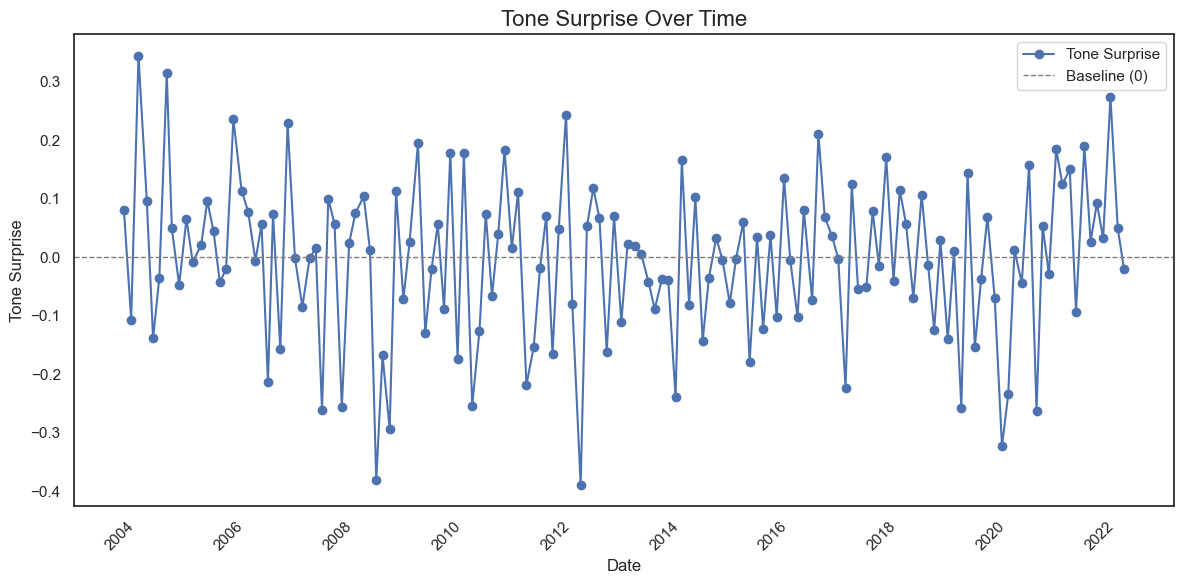

In [40]:
# Plot tone_surprise over time
plt.figure(figsize=(12, 6))
plt.plot(predict_data['DATE'], tone_surprise['tone_surprise'], marker='o', linestyle='-', label='Tone Surprise')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Baseline (0)')

# Add titles and labels
plt.title('Tone Surprise Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tone Surprise', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

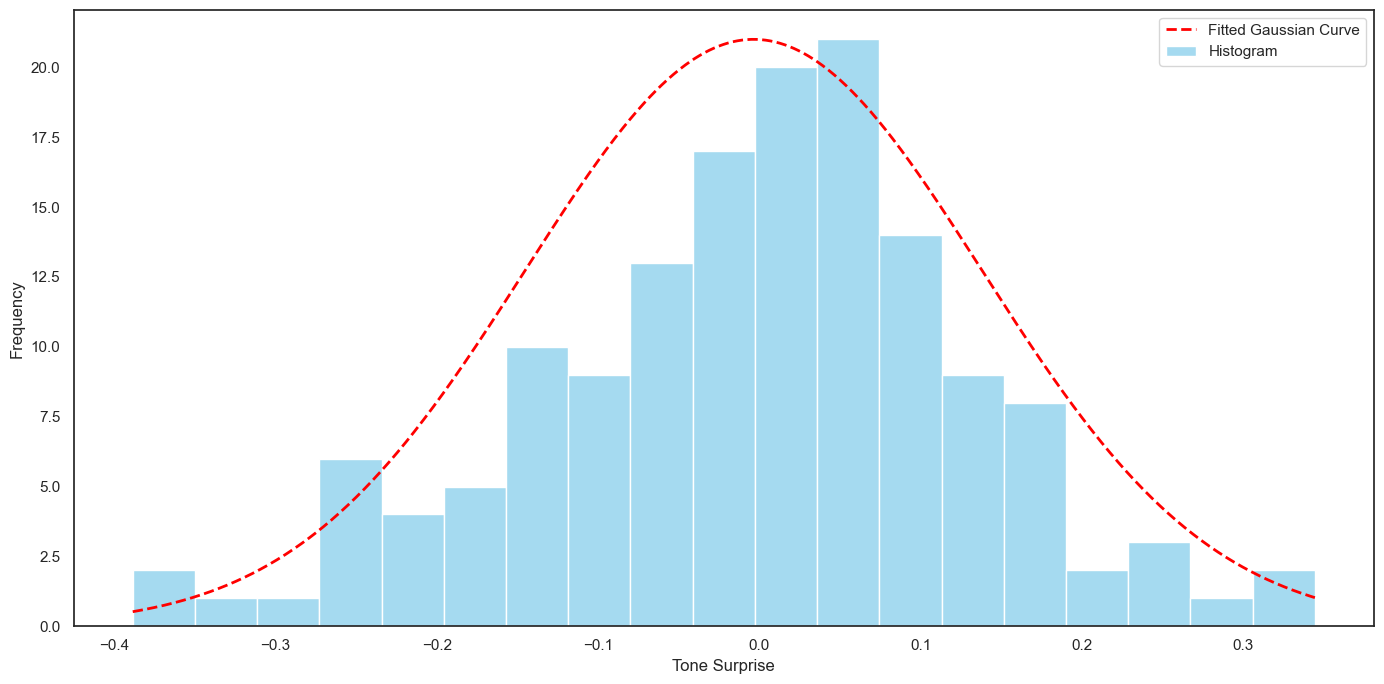

In [41]:
# Define the bins for tone_surprise
bins = np.linspace(tone_surprise['tone_surprise'].min(), tone_surprise['tone_surprise'].max(), 20)  # 20 bins
bin_labels = [f"{round(bins[i], 2)} to {round(bins[i + 1], 2)}" for i in range(len(bins) - 1)]

# Assign each tone_surprise value to a bin
tone_surprise_bin = tone_surprise.copy()
tone_surprise_bin['tone_surprise_bin'] = pd.cut(tone_surprise['tone_surprise'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate the frequency of each bin
tone_surprise_frequency = tone_surprise_bin['tone_surprise_bin'].value_counts().sort_index()

# Compute KDE to estimate parameters
plt.figure(figsize=(14, 7))
kde = gaussian_kde(tone_surprise['tone_surprise'], bw_method=0.5)
x_kde = np.linspace(tone_surprise['tone_surprise'].min(), tone_surprise['tone_surprise'].max(), 1000)
y_kde = kde(x_kde)

# Calculate the empirical mean and standard deviation from KDE
empirical_mean = np.sum(x_kde * y_kde) / np.sum(y_kde)
empirical_std = np.sqrt(np.sum((x_kde - empirical_mean) ** 2 * y_kde) / np.sum(y_kde))

# Generate the x values for the bell curve
x = np.linspace(tone_surprise['tone_surprise'].min(), tone_surprise['tone_surprise'].max(), 1000)

# Generate the Gaussian curve using KDE-estimated parameters
bell_curve = norm.pdf(x, empirical_mean, empirical_std)
bell_curve = bell_curve / bell_curve.max() * tone_surprise_frequency.max()  # Scale the curve to match histogram height

# Plot the histogram
sns.histplot(tone_surprise['tone_surprise'], bins=bins, kde=False, stat="count", color="skyblue", label="Histogram")

# Overlay the fitted Gaussian curve
plt.plot(x, bell_curve, color='red', linewidth=2, label='Fitted Gaussian Curve', linestyle="--")

# Add labels, title, and legend
#plt.title('Frequency Distribution of Tone Surprise with Fitted Gaussian Curve', fontsize=16)
plt.xlabel('Tone Surprise', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Frequency Distribution of tone surprise.png')
plt.show()

Observed KS Statistic: 0.0676
P-Value from Permutation Test: 0.8902


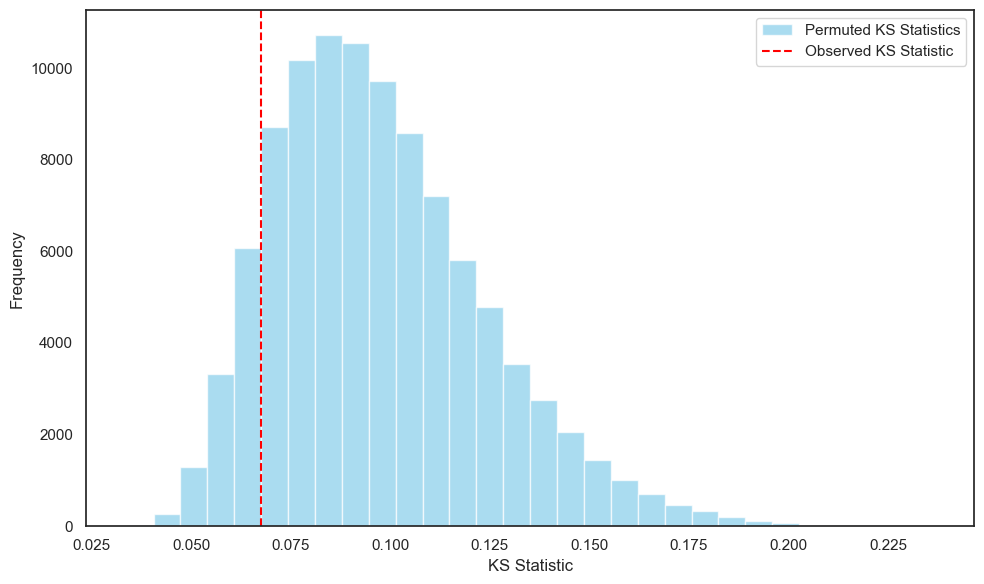

In [42]:
# Original distribution parameters
empirical_mean = tone_surprise['tone_surprise'].mean()
empirical_std = tone_surprise['tone_surprise'].std()

# Observed data
observed_data = tone_surprise['tone_surprise']

# Generate the normal distribution using the observed mean and std
normal_sample = np.random.normal(empirical_mean, empirical_std, len(observed_data))

# Test Statistic: Kolmogorov-Smirnov (KS) statistic
observed_ks_stat, _ = ks_2samp(observed_data, normal_sample)

# Permutation Test
n_permutations = 100000  # Number of permutations
permuted_ks_stats = []

for _ in range(n_permutations):
    # Permute observed data
    permuted_data = np.random.permutation(observed_data)
    
    # Generate normal sample for the permuted data
    permuted_normal_sample = np.random.normal(empirical_mean, empirical_std, len(permuted_data))
    
    # Compute the KS statistic for the permuted data
    ks_stat, _ = ks_2samp(permuted_data, permuted_normal_sample)
    permuted_ks_stats.append(ks_stat)

# Calculate p-value
permuted_ks_stats = np.array(permuted_ks_stats)
p_value = np.sum(permuted_ks_stats >= observed_ks_stat) / n_permutations

# Print Results
print(f"Observed KS Statistic: {observed_ks_stat:.4f}")
print(f"P-Value from Permutation Test: {p_value:.4f}")

# Plot the distribution of permuted KS statistics
plt.figure(figsize=(10, 6))
plt.hist(permuted_ks_stats, bins=30, alpha=0.7, label="Permuted KS Statistics", color="skyblue")
plt.axvline(observed_ks_stat, color="red", linestyle="--", label="Observed KS Statistic")
#plt.title("Permutation Test: KS Statistics", fontsize=16)
plt.xlabel("KS Statistic", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Permutation_KS_Statistic.png')
plt.show()

##### Rotation of the matrix to align with tone surprise

In [43]:
# Merge 'dataset4_pc' with 'tone_surprise' on 'Date'
merged_data_tone_surprise = pd.merge(dataset4_pc, tone_surprise[['Date', 'tone_surprise']], on='Date', how='inner')

# Drop all rows with NaN values
merged_data_tone_surprise = merged_data_tone_surprise.dropna()

# Compute correlation for the specific monetary surprise
correlations_tone_surprise = merged_data_tone_surprise[['Principal_Component_1', 'Principal_Component_2', 'tone_surprise']].corr()

# Extract correlations between PCs and 'mp_surprise_gb30d_01m_fut'
correlation_results_tone_surprise = correlations_tone_surprise.loc[
    ['Principal_Component_1', 'Principal_Component_2'], 'tone_surprise'
]

# Display the correlation results
print("Correlations between Principal Components and 'tone_surprise':")
print(correlation_results)

Correlations between Principal Components and 'tone_surprise':
Principal_Component_1    0.041299
Principal_Component_2   -0.009793
Name: mp_surprise_gb30d_01m_fut, dtype: float64


In [44]:
# Extract F1 and F2 from your dataset
F1 = merged_data_tone_surprise['Principal_Component_1'].values
F2 = merged_data_tone_surprise['Principal_Component_2'].values

# Extract mp_surprise_gb30d_01m_fut as y
y = merged_data_tone_surprise['tone_surprise'].values

# Center the data
F = np.column_stack((F1, F2))
F_centered = F - np.mean(F, axis=0)
y_centered = y - np.mean(y)

# Compute the covariance vector b
b = F_centered.T @ y_centered  # Shape: (2,)

# Compute the optimal direction w
w = b / np.linalg.norm(b)

# Find an orthogonal vector u
u = np.array([-w[1], w[0]])  # Rotate w by 90 degrees
u = u / np.linalg.norm(u)

# Construct the rotation matrix R
R = np.column_stack((w, u))  # Shape: (2, 2)

# Verify that R is orthonormal
assert np.allclose(R.T @ R, np.identity(2)), "Rotation matrix R is not orthonormal."

# Rotate the centered data
Z = F_centered @ R

# Compute correlations with the target variable
correlation_Z1 = np.corrcoef(Z[:, 0], y_centered)[0, 1]
correlation_Z2 = np.corrcoef(Z[:, 1], y_centered)[0, 1]

# Print the correlations
print("Rotation matrix:")
print(R)
print("Correlation between Z1 and tone_surprise:", correlation_Z1)
print("Correlation between Z2 and tone_surprise:", correlation_Z2)

Rotation matrix:
[[-0.97683375  0.21399961]
 [-0.21399961 -0.97683375]]
Correlation between Z1 and tone_surprise: 0.10008351960838936
Correlation between Z2 and tone_surprise: -1.0947532879604857e-17


## 2.3. Re-Running the Analysis and Splitting Data by Relevant Period

### 2.3.1. Visualization

/var/folders/pn/d006c06d1r75x7885zwbf6kc0000gn/T/ipykernel_64271/952453714.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fed_filtered_data['shift'] = is_below_threshold.ne(is_below_threshold.shift()).cumsum()


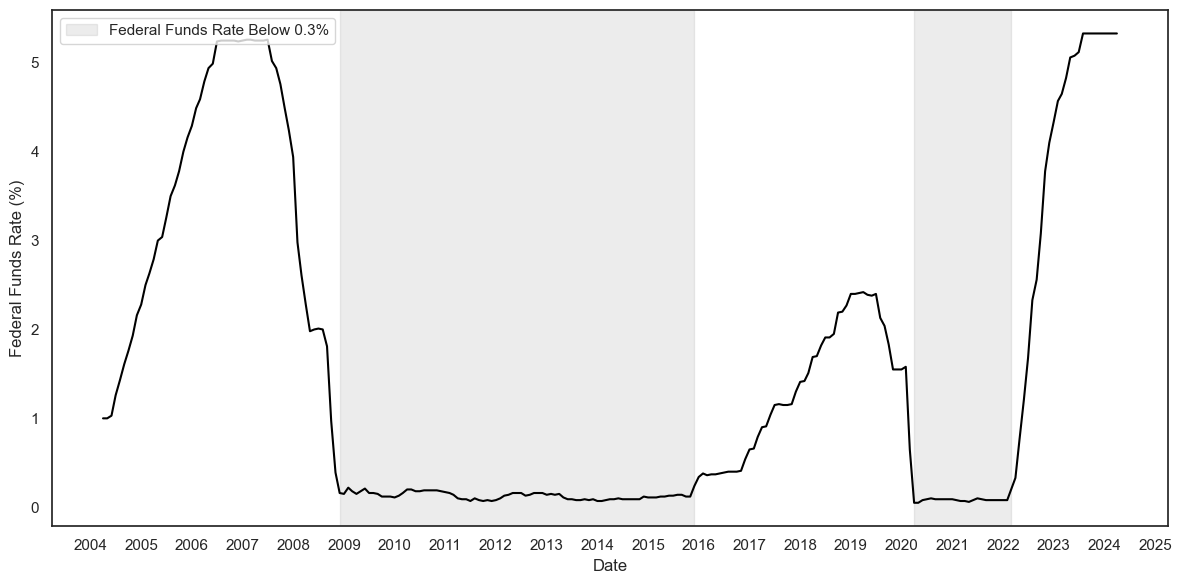

In [45]:
# Load the CSV file
file_path = './1. Database/Financial Data/FRED_data/FEDFUNDS.csv'
fedfunds_data = pd.read_csv(file_path)

# Convert the 'DATE' column to datetime format
fedfunds_data['DATE'] = pd.to_datetime(fedfunds_data['DATE'])

# Filter the data for the specified date range
fed_filtered_data = fedfunds_data[
    (fedfunds_data['DATE'] >= '2004-04-01') & (fedfunds_data['DATE'] <= '2024-04-01')
]

# Define periods where the Federal Funds Rate is below a Threshold
threshold = 0.3
below_threshold_periods = []
is_below_threshold = fed_filtered_data['FEDFUNDS'] < threshold
fed_filtered_data['shift'] = is_below_threshold.ne(is_below_threshold.shift()).cumsum()
grouped = fed_filtered_data[is_below_threshold].groupby('shift')
for _, group in grouped:
    below_threshold_periods.append((group['DATE'].iloc[0], group['DATE'].iloc[-1]))

# Plot the Federal Funds Rate
fig, ax = plt.subplots(figsize=(12, 6))

# Add shaded areas for periods where the rate is below 1%
for start, end in below_threshold_periods:
    ax.axvspan(start, end, color='grey', alpha=0.15, zorder=1)

# Line plot for the Federal Funds Rate
ax.plot(fed_filtered_data['DATE'], fed_filtered_data['FEDFUNDS'], color='black', label='Federal Funds Rate')

# Format the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add labels, title, and legend
#ax.set_title('Federal Funds Effective Rate', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Federal Funds Rate (%)', fontsize=12)
ax.legend([f'Federal Funds Rate Below {threshold}%'], loc='upper left')

plt.tight_layout()
plt.savefig('Federal Funds Effective Rate.png')
plt.show()

In [46]:
fed_filtered_data

,DATE,FEDFUNDS,shift
597,2004-04-01,1.00,1
598,2004-05-01,1.00,1
599,2004-06-01,1.03,1
600,2004-07-01,1.26,1
601,2004-08-01,1.43,1
...,...,...,...
833,2023-12-01,5.33,5
834,2024-01-01,5.33,5
835,2024-02-01,5.33,5
836,2024-03-01,5.33,5


### 2.3.2. Market Surprise - Actions

In [47]:
merged_data_monetary_surprise['Date'] = pd.to_datetime(merged_data_monetary_surprise['Date'], errors='coerce')

In [48]:
# Perform an asof merge to combine dataset4_with_date with filtered_data
# Sort both DataFrames by the date column for asof merge
merged_monetary_surprise = pd.merge_asof(
    merged_data_monetary_surprise.sort_values(by='Date'),
    fed_filtered_data[['DATE', 'FEDFUNDS']].sort_values(by='DATE'),  # Ensure filtered_data is sorted by 'DATE'
    left_on='Date',
    right_on='DATE',
    direction='backward'  # Match the most recent prior date
)

# Create merged_data_monetary_surprise_low with rows where FEDFUNDS < 1.00
merged_data_monetary_surprise_low = merged_monetary_surprise[merged_monetary_surprise['FEDFUNDS'] < 0.3].drop(columns=['Date', 'DATE', 'FEDFUNDS'])

# Create merged_data_monetary_surprise_normal with rows where FEDFUNDS >= 1.00
merged_data_monetary_surprise_normal = merged_monetary_surprise[merged_monetary_surprise['FEDFUNDS'] >= 0.3].drop(columns=['Date', 'DATE', 'FEDFUNDS'])

# Display confirmation messages
print("merged_data_monetary_surprise_low and merged_data_monetary_surprise_normal created successfully.")

print(merged_data_monetary_surprise_low.shape)
print(merged_data_monetary_surprise_normal.shape)

merged_data_monetary_surprise_low and merged_data_monetary_surprise_normal created successfully.
(83, 3)
(56, 3)


In [49]:
# Define a function to calculate correlations
def calculate_correlations(data, monetary_surprise_column='mp_surprise_gb30d_01m_fut'):
    correlations = data[['Principal_Component_1', 'Principal_Component_2', monetary_surprise_column]].corr()
    return correlations.loc[['Principal_Component_1', 'Principal_Component_2'], monetary_surprise_column]

# Calculate correlations for merged_data_monetary_surprise_low
print("Correlations for merged_data_monetary_surprise_low:")
correlation_results_low = calculate_correlations(merged_data_monetary_surprise_low)
print(correlation_results_low)

# Calculate correlations for merged_data_monetary_surprise_normal
print("\nCorrelations for merged_data_monetary_surprise_normal:")
correlation_results_normal = calculate_correlations(merged_data_monetary_surprise_normal)
print(correlation_results_normal)

Correlations for merged_data_monetary_surprise_low:
Principal_Component_1    0.210350
Principal_Component_2    0.109206
Name: mp_surprise_gb30d_01m_fut, dtype: float64

Correlations for merged_data_monetary_surprise_normal:
Principal_Component_1    0.043354
Principal_Component_2   -0.041168
Name: mp_surprise_gb30d_01m_fut, dtype: float64


In [50]:
# Define a function to perform the analysis for a given dataset
def compute_rotations_and_correlations(dataset, target_column='mp_surprise_gb30d_01m_fut'):
    # Extract F1, F2, and y
    F1 = dataset['Principal_Component_1'].values
    F2 = dataset['Principal_Component_2'].values
    y = dataset[target_column].values

    # Center the data
    F = np.column_stack((F1, F2))
    F_centered = F - np.mean(F, axis=0)
    y_centered = y - np.mean(y)

    # Compute the covariance vector b
    b = F_centered.T @ y_centered  # Shape: (2,)

    # Compute the optimal direction w
    w = b / np.linalg.norm(b)

    # Find an orthogonal vector u
    u = np.array([-w[1], w[0]])  # Rotate w by 90 degrees
    u = u / np.linalg.norm(u)

    # Construct the rotation matrix R
    R = np.column_stack((w, u))  # Shape: (2, 2)

    # Verify that R is orthonormal
    assert np.allclose(R.T @ R, np.identity(2)), "Rotation matrix R is not orthonormal."

    # Rotate the centered data
    Z = F_centered @ R

    # Compute correlations with the target variable
    correlation_Z1 = np.corrcoef(Z[:, 0], y_centered)[0, 1]
    correlation_Z2 = np.corrcoef(Z[:, 1], y_centered)[0, 1]

    return R, correlation_Z1, correlation_Z2

# Perform the analysis for merged_data_monetary_surprise_low
print("Analysis for merged_data_monetary_surprise_low:")
R_low, correlation_Z1_low, correlation_Z2_low = compute_rotations_and_correlations(merged_data_monetary_surprise_low)
print("Rotation matrix (low):")
print(R_low)
print("Correlation between Z1 and target (low):", correlation_Z1_low)
print("Correlation between Z2 and target (low):", correlation_Z2_low)

# Perform the analysis for merged_data_monetary_surprise_normal
print("\nAnalysis for merged_data_monetary_surprise_normal:")
R_normal, correlation_Z1_normal, correlation_Z2_normal = compute_rotations_and_correlations(merged_data_monetary_surprise_normal)
print("Rotation matrix (normal):")
print(R_normal)
print("Correlation between Z1 and target (normal):", correlation_Z1_normal)
print("Correlation between Z2 and target (normal):", correlation_Z2_normal)

Analysis for merged_data_monetary_surprise_low:
Rotation matrix (low):
[[ 0.97145419 -0.23722723]
 [ 0.23722723  0.97145419]]
Correlation between Z1 and target (low): 0.21859248690132035
Correlation between Z2 and target (low): -1.005776938625292e-17

Analysis for merged_data_monetary_surprise_normal:
Rotation matrix (normal):
[[ 0.94505302  0.32691708]
 [-0.32691708  0.94505302]]
Correlation between Z1 and target (normal): 0.04698574529283547
Correlation between Z2 and target (normal): -7.343991519520388e-18


### 2.3.3. Market Surprise - Words (Tone Surprise)

In [51]:
# Perform an asof merge to combine dataset4_with_date with filtered_data
# Sort both DataFrames by the date column for asof merge
merged_tone_surprise = pd.merge_asof(
    merged_data_tone_surprise.sort_values(by='Date'),
    fed_filtered_data[['DATE', 'FEDFUNDS']].sort_values(by='DATE'),  # Ensure filtered_data is sorted by 'DATE'
    left_on='Date',
    right_on='DATE',
    direction='backward'  # Match the most recent prior date
)

# Create merged_data_tone_surprise_low with rows where FEDFUNDS < 1.00
merged_data_tone_surprise_low = merged_tone_surprise[merged_tone_surprise['FEDFUNDS'] < 0.3].drop(columns=['Date', 'DATE', 'FEDFUNDS'])

# Create merged_data_tone_surprise_normal with rows where FEDFUNDS >= 1.00
merged_data_tone_surprise_normal = merged_tone_surprise[merged_tone_surprise['FEDFUNDS'] >= 0.3].drop(columns=['Date', 'DATE', 'FEDFUNDS'])

# Display confirmation messages
print("merged_data_tone_surprise_low and merged_data_tone_surprise_normal created successfully.")

print(merged_data_tone_surprise_low.shape)
print(merged_data_tone_surprise_normal.shape)

merged_data_tone_surprise_low and merged_data_tone_surprise_normal created successfully.
(72, 3)
(35, 3)


In [52]:
# Calculate correlations for merged_data_monetary_surprise_low
print("Correlations for merged_data_tone_surprise_low:")
correlation_results_tone_low = calculate_correlations(merged_data_tone_surprise_low, monetary_surprise_column='tone_surprise')
print(correlation_results_tone_low)

# Calculate correlations for merged_data_tone_surprise_normal
print("\nCorrelations for merged_data_tone_surprise_normal:")
correlation_results_tone_normal = calculate_correlations(merged_data_tone_surprise_normal, monetary_surprise_column='tone_surprise')
print(correlation_results_tone_normal)

Correlations for merged_data_tone_surprise_low:
Principal_Component_1    0.035271
Principal_Component_2   -0.037146
Name: tone_surprise, dtype: float64

Correlations for merged_data_tone_surprise_normal:
Principal_Component_1   -0.409184
Principal_Component_2   -0.068376
Name: tone_surprise, dtype: float64


In [53]:
# Perform the analysis for merged_data_tone_surprise_low
print("Analysis for merged_data_tone_surprise_low:")
R_low, correlation_Z1_low, correlation_Z2_low = compute_rotations_and_correlations(merged_data_tone_surprise_low, target_column='tone_surprise')
print("Rotation matrix (low):")
print(R_low)
print("Correlation between Z1 and target (low):", correlation_Z1_low)
print("Correlation between Z2 and target (low):", correlation_Z2_low)

# Perform the analysis for merged_data_tone_surprise_normal
print("\nAnalysis for merged_data_tone_surprise_normal:")
R_normal, correlation_Z1_normal, correlation_Z2_normal = compute_rotations_and_correlations(merged_data_tone_surprise_normal, target_column='tone_surprise')
print("Rotation matrix (normal):")
print(R_normal)
print("Correlation between Z1 and target (normal):", correlation_Z1_normal)
print("Correlation between Z2 and target (normal):", correlation_Z2_normal)

Analysis for merged_data_tone_surprise_low:
Rotation matrix (low):
[[ 0.89048292  0.45501666]
 [-0.45501666  0.89048292]]
Correlation between Z1 and target (low): 0.04414941334405889
Correlation between Z2 and target (low): -6.643570067236798e-18

Analysis for merged_data_tone_surprise_normal:
Rotation matrix (normal):
[[-0.99742479  0.07172014]
 [-0.07172014 -0.99742479]]
Correlation between Z1 and target (normal): 0.41445828322867617
Correlation between Z2 and target (normal): 1.151422949452041e-17


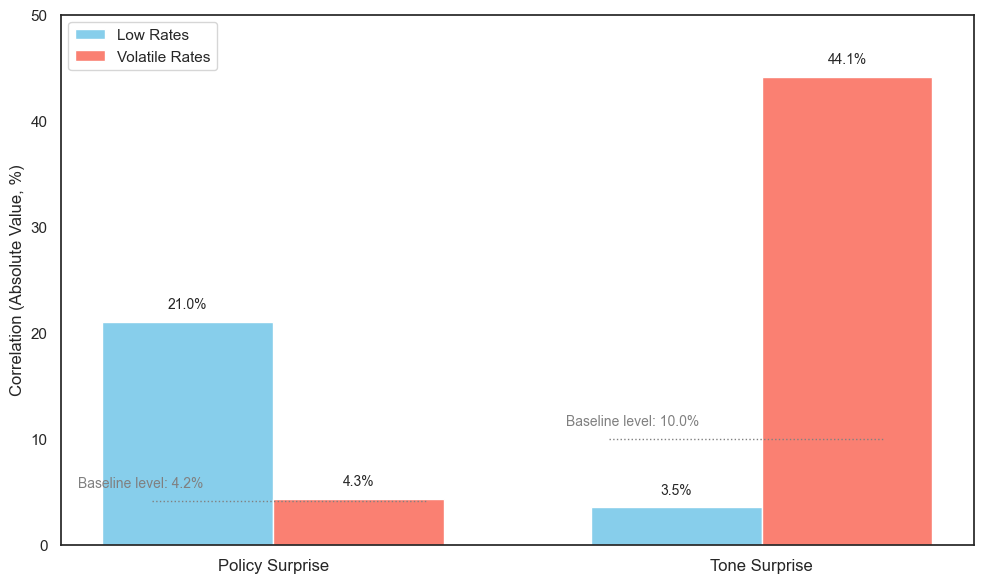

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ["Policy Surprise", "Tone Surprise"]
low_rates = [0.210350, 0.035271]
normal_rates = [0.043354, 0.44149]

# Baseline levels
baselines = [0.041689, 0.10008]

# Bar positions
x = np.arange(len(categories))
width = 0.35  # Bar width

# Plot
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width / 2, [val * 100 for val in low_rates], width, label="Low Rates", color="skyblue")
bars2 = plt.bar(x + width / 2, [val * 100 for val in normal_rates], width, label="Volatile Rates", color="salmon")

# Add baseline lines with labels
plt.axhline(baselines[0] * 100, color='gray', linestyle='dotted', linewidth=1, xmin=0.1, xmax=0.4)
plt.text(-0.4, baselines[0] * 100 + 1, f"Baseline level: {baselines[0] * 100:.1f}%", color='gray', fontsize=10, va='bottom')
plt.axhline(baselines[1] * 100, color='gray', linestyle='dotted', linewidth=1, xmin=0.6, xmax=0.9)
plt.text(0.6, baselines[1] * 100 + 1, f"Baseline level: {baselines[1] * 100:.1f}%", color='gray', fontsize=10, va='bottom')

# Add labels (values in %)
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', va='bottom', fontsize=10)

# Labels and title
#plt.title("Correlation Between PC1 and Metrics by Rate Environment", fontsize=16)
plt.xticks(x, categories, fontsize=12)
plt.ylabel("Correlation (Absolute Value, %)", fontsize=12)
plt.ylim(0, 50)  # Adjust the range to fit all bars and labels
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('results_split_by_period_with_labels.png')

# Show the plot
plt.show()